In [1]:
import torch
import stylegan2_pytorch
import torchvision.transforms.functional as F
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

/mnt/nfs/home/u.tanielian/image_cuda/stylegan2-pytorch/venv/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
state_dict = torch.load('./models/wasserstein_GP15/model_150.pt')
model = stylegan2_pytorch.StyleGAN2(128)
model.load_state_dict(state_dict['GAN'])
model.to('cuda:0')
model.eval()

StyleGAN2(
  (S): StyleVectorizer(
    (net): Sequential(
      (0): EqualLinear()
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): EqualLinear()
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): EqualLinear()
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): EqualLinear()
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): EqualLinear()
      (9): LeakyReLU(negative_slope=0.2, inplace=True)
      (10): EqualLinear()
      (11): LeakyReLU(negative_slope=0.2, inplace=True)
      (12): EqualLinear()
      (13): LeakyReLU(negative_slope=0.2, inplace=True)
      (14): EqualLinear()
      (15): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (G): Generator(
    (initial_conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): GeneratorBlock(
        (to_style1): Linear(in_features=512, out_features=512, bias=True)
        (to_noise1): Linear(in_features=1, out_featur

In [3]:
# transform = transforms.ToTensor()
# img1 = Image.open('/home/jycja.franceschi/notebooks/img/00018.png')
# img2 = Image.open('/home/jycja.franceschi/notebooks/img/00045.png')
# img1 = transform(img1).to('cuda:0')
# img2 = transform(img2).to('cuda:0')
# display(F.to_pil_image(img1), F.to_pil_image(img2))

In [3]:
import numpy as np
from stylegan2_pytorch.stylegan2_pytorch import noise_list, image_noise, \
    evaluate_in_chunks, noise, styles_def_to_tensor
    #generate_interpolation

@torch.no_grad()
def define_av(model):
    z = noise(2000, model.G.latent_dim, device='cuda')
    samples = evaluate_in_chunks(10, model.S, z).cpu().numpy()
    model.G.av = np.mean(samples, axis = 0)
    model.G.av = np.expand_dims(model.G.av, axis = 0)

#@torch.no_grad()
def truncate_style(tensor, trunc_psi = 0.75):
    av_torch = torch.from_numpy(model.G.av).cuda('cuda')
    tensor = trunc_psi * (tensor - av_torch) + av_torch
    return tensor

def truncate_style_defs(w, trunc_psi = 0.75):
    w_space = []
    for tensor, num_layers in w:
        tensor = truncate_style(tensor, trunc_psi = trunc_psi)            
        w_space.append((tensor, num_layers))
    return w_space

def generate_truncated(S, G, style, noi, trunc_psi = 0.75, num_image_tiles = 8):
    w = map(lambda t: (S(t[0]), t[1]), style)
    w_truncated = truncate_style_defs(w, trunc_psi = trunc_psi)
    w_styles = styles_def_to_tensor(w_truncated)
    generated_images = evaluate_in_chunks(batch_size, G, w_styles, noi)
    return generated_images.clamp_(0., 1.)



In [4]:
from tqdm import tqdm 
import torchvision

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(17,17))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def slerp(val, low, high):
    low_norm = low / torch.norm(low, dim=1, keepdim=True)
    high_norm = high / torch.norm(high, dim=1, keepdim=True)
    omega = torch.acos((low_norm * high_norm).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.0 - val) * omega) / so).unsqueeze(1) * low + (torch.sin(val * omega) / so).unsqueeze(1) * high
    return res

In [27]:
def select_start_and_end_images(threshold):
    cont=True
    while cont:
        batch_size = 2
        latents_bs = noise_list(batch_size, num_layers, latent_dim, device='cuda')
        noise_single = image_noise(1, image_size, device='cuda')
        noise_bs = noise_single.repeat(batch_size, 1, 1, 1)
        generated_images = generate_truncated(model.SE, model.GE, latents_bs, noise_single, trunc_psi = 0.5)
        output_disc_images = output_discriminator(generated_images)
        if np.amin(output_disc_images)>threshold:
            break
    return latents_bs, noise_single

@torch.no_grad()
def output_discriminator(generated_images):
    outs = model.D(generated_images)[0].cpu().numpy()
    return np.array(outs)

def linear_interpolation(img1, img2, steps):
    images = [(1-k/steps)*img1 + ((k/steps))*img2 for k in range(steps+1)]
    outputs_D = [model.D(img.unsqueeze(0))[0].detach().cpu().numpy() for img in images]
    return images, outputs_D

def gan_interpolation(latents, noise_single, steps, slerpB):
    latent1, latent2 = latents[0][0][0].unsqueeze(0), latents[0][0][1].unsqueeze(0)
    images, latents, outputs_D = list(), list(), list()
    for k in range(steps+1):
        if slerpB:
            latent_inter = slerp((1-k/steps), latent2, latent1)
        else:
            latent_inter = (1-k/steps)*latent1 + ((k/steps))*latent2
        latent_inter = [(latent_inter, num_layers)]
        img = generate_truncated(model.SE, model.GE, latent_inter, noise_single, trunc_psi = 0.5)
        images.append(img[0])
        latents.append(latent_inter)
        outputs_D.append(model.D(img)[0].detach().cpu().numpy())
    return images, latents, np.array(outputs_D)

def discriminator_latent_interpolation(model, img1, img2, latent1, latent2, emb1, emb2, \
                                noise_single, steps, n_updates, lr, trunc_psi=0.7):
    outputs_D = list()
    images = list()
    latents = list()
    
    for k in range(steps+1):
        emb = ((1-k/steps)*emb1 + ((k/steps))*emb2).detach()
        img = ((1-k/steps)*img1 + ((k/steps))*img2).detach()
        latent_inter = slerp((1-k/steps), latent2[0][0], latent1[0][0])
        latent_init = latent1[0][0] #torch.randn_like(latent_inter)
        z = [(torch.clone(latent_init), num_layers)]
        z[0][0].cuda()
        z[0][0].requires_grad_(True)
        optimizer = torch.optim.Adam([z[0][0]], lr= lr)
        torch.autograd.set_detect_anomaly(True)
        print("")
       
        for update in range(n_updates):
            model.eval()
            gz = generate_truncated(model.SE, model.GE, z, noise_single, trunc_psi)
            #image_embedding = model.D.return_embedding(gz).float()
            #loss = torch.sum((image_embedding-emb)**2)
            loss = torch.sum((gz-img)**2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if update%25==0:
                print(k, update, \
                      torch.sum((latent_init-latent_inter)**2).cpu().detach().numpy(),\
                      torch.sum((latent_init-z[0][0])**2).cpu().detach().numpy(),\
                      torch.sum((z[0][0]-latent_inter)**2).cpu().detach().numpy(),\
                      loss.cpu().detach().numpy())
                
        latents.append(z)
        outputs_D.append(model.D(gz)[0].detach().cpu().numpy())
        images.append(gz[0])
    return images, outputs_D


def discriminator_image_interpolation(model, img1, img2, latent1, latent2, emb1, emb2, \
                                noise_single, steps, n_updates, lr, trunc_psi=0.7):
    outputs_D = list()
    images = list()
    
    for k in range(steps+1):
        emb = ((1-k/steps)*emb1 + ((k/steps))*emb2).detach()
        img = ((1-k/steps)*img1 + ((k/steps))*img2)
        img_init = torch.clone(img)
        img.cuda()
        img.requires_grad_(True)
        optimizer = torch.optim.Adam([img], lr= lr)
        torch.autograd.set_detect_anomaly(True)
        print("")
       
        for update in range(n_updates):
            model.eval()
            image_embedding = model.D.return_embedding_before_final_conv(img.unsqueeze(0)).float()
            loss = torch.sum((image_embedding-emb)**2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if update%25==0:
                print(k, update, loss.cpu().detach().numpy())
                
        outputs_D.append(model.D(img.unsqueeze(0))[0].detach().cpu().numpy())
        images.append(img)
    return images, outputs_D


def get_discriminator_embeddings_distance():
    dist = list()
    for i in range(len(embs)-1):
        dist.append(torch.cdist(embs[i].unsqueeze(dim=0), embs[i+1].unsqueeze(dim=0)).cpu().numpy()[0][0])
    print(sum(outs)/len(outs), sum(dist))
    return outs


def plot_outputs_discriminator(outputs, labels, steps):
    plt.clf()
    for i in range(len(outputs)):
        plt.plot(np.arange(steps), outputs[i], label=labels[i])
    plt.legend()
    plt.show()


disc inter

0 0 0.0 1.2799995 1.2799995 311.06927
0 25 0.0 13.441706 13.441706 195.45764
0 50 0.0 18.959942 18.959942 121.57711
0 75 0.0 20.929623 20.929623 121.71596

1 0 18.412888 1.2799994 19.621399 346.74875
1 25 18.412888 15.291264 35.07434 197.91742
1 50 18.412888 21.98126 41.839073 146.0504
1 75 18.412888 24.708591 44.950638 127.57498

2 0 73.12491 1.2799995 73.90554 471.07895
2 25 73.12491 18.856243 93.63839 236.59297
2 50 73.12491 25.706333 100.53914 164.58669
2 75 73.12491 29.675236 105.25139 139.72534

3 0 162.60355 1.2799995 162.44577 684.05994
3 25 162.60355 18.781822 183.27367 257.91266
3 50 162.60355 25.054111 188.15846 201.27127
3 75 162.60355 29.130571 193.08345 183.13953

4 0 284.28186 1.2799995 283.57446 985.69165
4 25 284.28186 20.044533 307.42346 240.65259
4 50 284.28186 25.546442 311.97623 190.47517
4 75 284.28186 27.263966 314.05322 178.54927

5 0 434.48962 1.2799995 434.6095 1375.9741
5 25 434.48962 23.69701 462.93683 204.00793
5 50 434.48962 32.79122 472.31134 

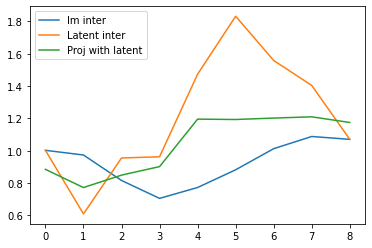

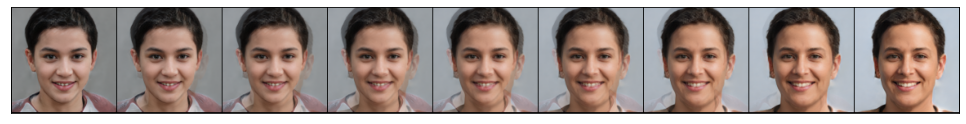

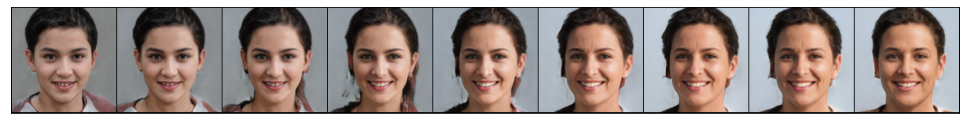

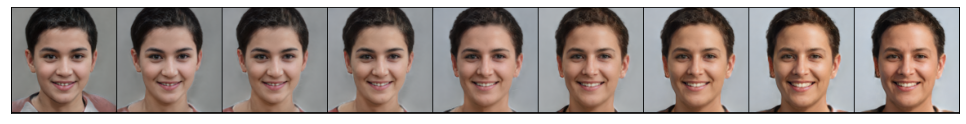

In [28]:
steps=8
batch_size=2
latent_dim = model.G.latent_dim
image_size = model.G.image_size
num_layers = model.G.num_layers
define_av(model)

latents_bs, noise_single = select_start_and_end_images(threshold=1.)
images_inter_gan, latents_inter_gan, D_gan = gan_interpolation(latents_bs, noise_single, steps=steps, slerpB=True)

img1, img2 = images_inter_gan[0], images_inter_gan[-1]
emb1, emb2 = model.D.return_embedding(img1.unsqueeze(0)), model.D.return_embedding(img2.unsqueeze(0))
latent1, latent2 = latents_inter_gan[0], latents_inter_gan[-1]

images_inter, outputs_D_inter = linear_interpolation(img1, img2, steps=steps)
print("disc inter")
images_disc_latentProj, outputs_D_latentProj = \
    discriminator_latent_interpolation(model, img1, img2, latent1, latent2, emb1, emb2, \
                                noise_single, n_updates=100, lr=5e-2, steps=steps)
# images_disc_imageinter, _ = \
#     discriminator_image_interpolation(model, img1, img2, latent1, latent2, emb1, emb2, \
#                                 noise_single, n_updates=100, lr=5e-2, steps=steps)


plot_outputs_discriminator([outputs_D_inter, D_gan, outputs_D_latentProj], \
                           ["Im inter", "Latent inter", "Proj with latent"], steps+1)
show(torchvision.utils.make_grid(images_inter, steps+1, padding=1, scale_each=True))
show(torchvision.utils.make_grid(images_inter_gan, steps+1, padding=1,scale_each=True))
show(torchvision.utils.make_grid(images_disc_latentProj, steps+1, padding=1,scale_each=True))

In [ ]:
lr = 0.005
steps = 1000
show_every = 100
start = (img1 + img2) / 2
x = start.clone().requires_grad_(True)
display(F.to_pil_image(start))
for i in range(steps):
    grad = torch.autograd.grad(model.D(x.unsqueeze(0))[0], x)[0]
    x = x - lr * grad
    if i % show_every == 0:
        display(F.to_pil_image(x))

In [30]:
# start = (img1)
# x = start.clone().requires_grad_(True)
# display(F.to_pil_image(start))
# for i in range(steps):
#     grad = torch.autograd.grad(model.D(x.unsqueeze(0))[0], x)[0]
#     x = x - lr * grad
#     if i % show_every == 0:
#         display(F.to_pil_image(x))

In [31]:
# start = (img2)
# x = start.clone().requires_grad_(True)
# display(F.to_pil_image(start))
# for i in range(steps):
#     grad = torch.autograd.grad(model.D(x.unsqueeze(0))[0], x)[0]
#     x = x - lr * grad
#     if i % show_every == 0:
#         display(F.to_pil_image(x))